In [2]:
import pandas as pd
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm
import time
pd.options.display.max_rows = 100

In [3]:
file_path = Path("../data/clean/recipes_cleaned_original.csv")
df = pd.read_csv(file_path)
df.head()

C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\88100931.py:2: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,RecipeId,Name,TotalTime,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,...,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,38,Low-Fat Berry Blue Frozen Dessert,24H45M,Make and share this Low-Fat Berry Blue Frozen ...,"""https://img.sndimg.com/food/image/upload/w_55...",Frozen Desserts,"""Dessert"", ""Low Protein"", ""Low Cholesterol"", ""...","""4"", ""1/4"", ""1"", ""1""","""blueberries"", ""granulated sugar"", ""vanilla yo...",4.5,...,37.1,3.6,30.2,3.2,4,"""Toss 2 cups berries with sugar."", ""Let stand ...",NaN,NaN,NaN,NaN
1,39,Biryani,4H25M,Make and share this Biryani recipe from Food.com.,"""https://img.sndimg.com/food/image/upload/w_55...",Chicken Breast,"""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"", ""...","""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ""1...","""saffron"", ""milk"", ""hot green chili peppers"", ...",3,...,84.4,9,20.4,63.4,6,"""Soak saffron in warm milk for 5 minutes and p...",NaN,NaN,NaN,NaN
2,40,Best Lemonade,35M,This is from one of my first Good House Keepi...,"""https://img.sndimg.com/food/image/upload/w_55...",Beverages,"""Low Protein"", ""Low Cholesterol"", ""Healthy"", ""...","""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4""","""sugar"", ""lemons, rind of"", ""lemon, zest of"", ...",4.5,...,81.5,0.4,77.2,0.3,4,"""Into a 1 quart Jar with tight fitting lid, pu...",NaN,NaN,NaN,NaN
3,41,Carina's Tofu-Vegetable Kebabs,24H20M,This dish is best prepared a day in advance to...,"""https://img.sndimg.com/food/image/upload/w_55...",Soy/Tofu,"""Beans"", ""Vegetable"", ""Low Cholesterol"", ""Week...","""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2"",...","""extra firm tofu"", ""eggplant"", ""zucchini"", ""mu...",4.5,...,64.2,17.3,32.1,29.3,2,"""Drain the tofu, carefully squeezing out exces...",NaN,NaN,NaN,NaN
4,42,Cabbage Soup,50M,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""He...","""46"", ""4"", ""1"", ""2"", ""1""","""plain tomato juice"", ""cabbage"", ""onion"", ""car...",4.5,...,25.1,4.8,17.7,4.3,4,"""Mix everything together and bring to a boil.""...",NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269095 entries, 0 to 269094
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   RecipeId                    269095 non-null  object
 1   Name                        269095 non-null  object
 2   TotalTime                   269095 non-null  object
 3   Description                 269095 non-null  object
 4   Images                      269095 non-null  object
 5   RecipeCategory              269094 non-null  object
 6   Keywords                    269093 non-null  object
 7   RecipeIngredientQuantities  269093 non-null  object
 8   RecipeIngredientParts       269093 non-null  object
 9   AggregatedRating            269090 non-null  object
 10  ReviewCount                 269084 non-null  object
 11  Calories                    269084 non-null  object
 12  FatContent                  269084 non-null  object
 13  SaturatedFatContent         2

In [5]:
# List of columns to convert to float
columns_to_float = ['AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent',
                    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                    'SugarContent', 'ProteinContent']

# Replace non-numeric values with NaN
df[columns_to_float] = df[columns_to_float].apply(pd.to_numeric, errors='coerce')

# Now, convert the columns to float
df[columns_to_float] = df[columns_to_float].astype(float)

In [6]:
# Read the keywords CSV file
keyword_categories = pd.read_csv(Path("../data/clean/keywords.csv"))

# Initialize a new 'Health' column with empty strings
df['Health'] = ''

# Iterate over the health categories from the CSV file
for health in tqdm(keyword_categories['Health'].dropna()):
    # Find rows in df where the 'Keywords' column contains the health category
    mask = df['Keywords'].str.contains(health, case=False, na=False)
    
    # Assign the original formatting of the health category to matching rows in df
    df.loc[mask, 'Health'] = health

  0%|          | 0/19 [00:00<?, ?it/s]

In [7]:
# Convert 'AggregatedRating' column to numeric
df['AggregatedRating'] = pd.to_numeric(df['AggregatedRating'], errors='coerce')

# Drop rows with missing values in 'AggregatedRating' column
df.dropna(subset=['AggregatedRating'], inplace=True)

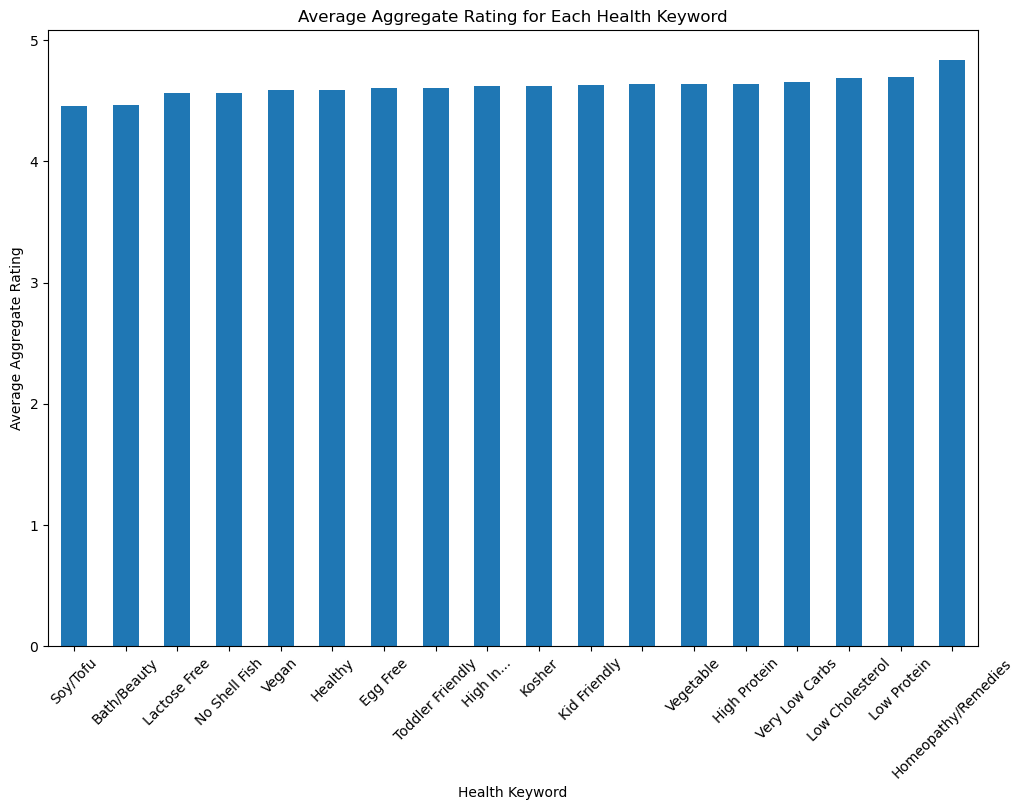

In [8]:
# Visualize the average aggregate rating for each health keyword
plt.figure(figsize=(12, 8))
df.groupby('Health')['AggregatedRating'].mean().sort_values().plot(kind='bar')
plt.title('Average Aggregate Rating for Each Health Keyword')
plt.xlabel('Health Keyword')
plt.ylabel('Average Aggregate Rating')
plt.xticks(rotation=45)
plt.show()

In [9]:
# List of columns to visualize against each health keyword
columns_to_visualize = ['Calories', 'FatContent', 'SaturatedFatContent', 
                        'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 
                        'FiberContent', 'SugarContent', 'ProteinContent']

In [10]:
# Filter out rows with missing or empty values in the 'Health' column
df_filtered = df[df['Health'].notna() & (df['Health'] != '')]

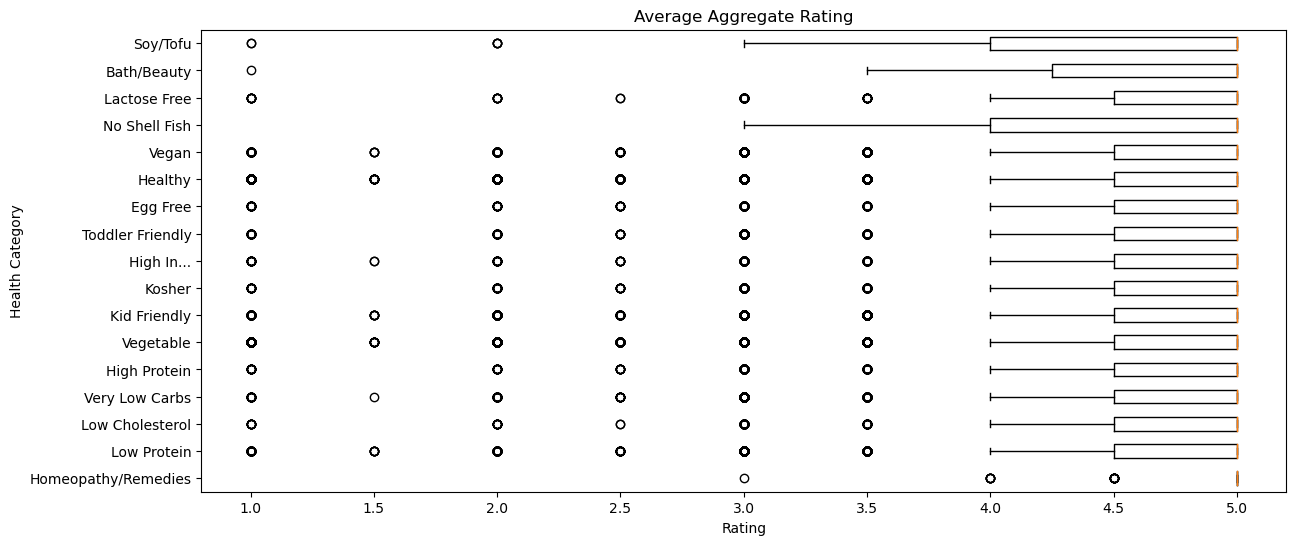

In [11]:
# Recreate the Health ranking based on the 'Health' column
Health_ranking = df_filtered.groupby('Health')['AggregatedRating'].mean().sort_values(ascending=False)

# Visualize the differences using matplotlib
plt.figure(figsize=(14, 6))
boxes = []
labels = []

for health in Health_ranking.index:
    # Filter out rows with missing or empty values in the 'AggregatedRating' column for each health category
    data = df_filtered[df_filtered['Health'] == health]['AggregatedRating']
    if not data.empty:  # Skip empty data
        boxes.append(data)
        labels.append(health)

plt.boxplot(boxes, labels=labels, vert=False)
plt.xlabel('Rating')
plt.ylabel('Health Category')
plt.title('Average Aggregate Rating')

# Save the plot as a JPEG image
plt.savefig('../images/health_rating_boxplot.jpg')

# Show the Plot
plt.show()

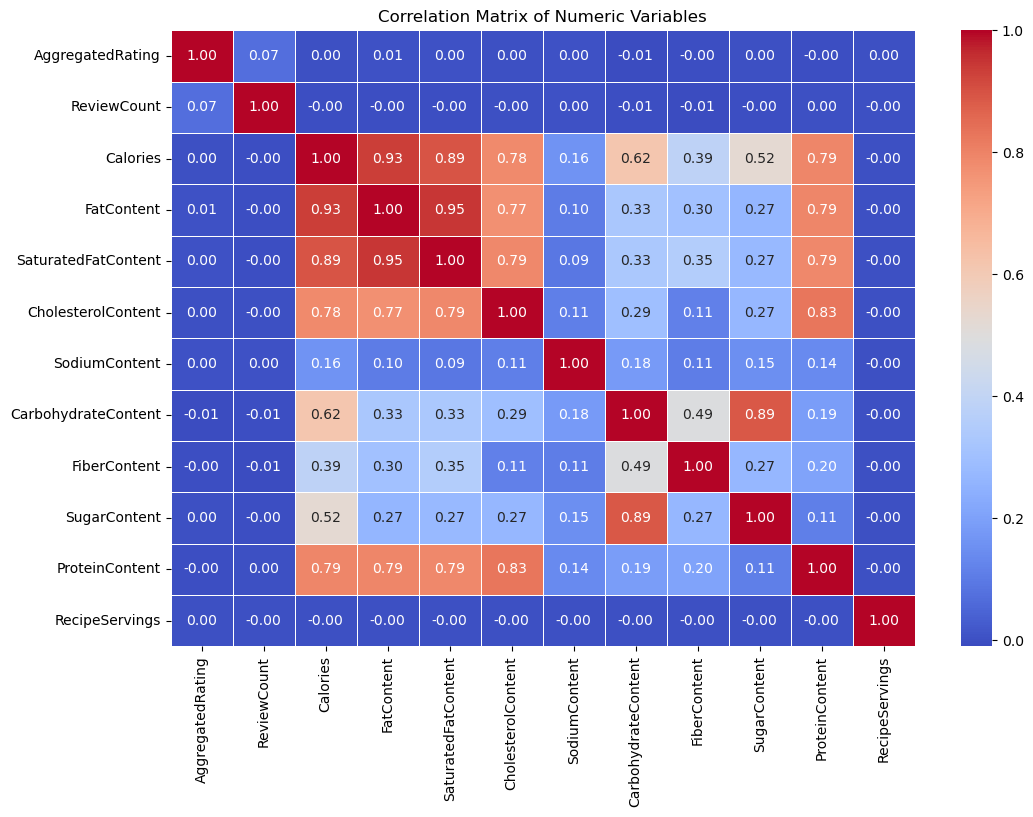

In [12]:
# Assuming your DataFrame is named df
numeric_columns = ['AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent',
                   'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                   'SugarContent', 'ProteinContent', 'RecipeServings']

# Selecting only the numeric columns
numeric_df = df[numeric_columns]

# Calculating the correlation matrix
correlation_matrix = numeric_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.savefig('../images/correlation_matrix.jpg')
plt.show()

C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


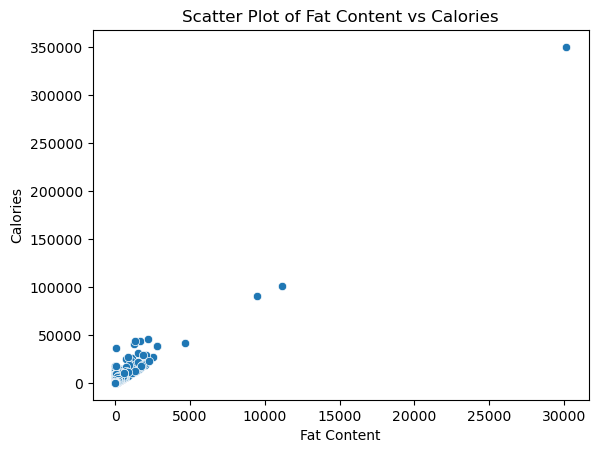

In [13]:
# Scatter plot
sns.scatterplot(data=df, x='FatContent', y='Calories')
plt.title('Scatter Plot of Fat Content vs Calories')
plt.xlabel('Fat Content')
plt.ylabel('Calories')

plt.show()


C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cjche\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

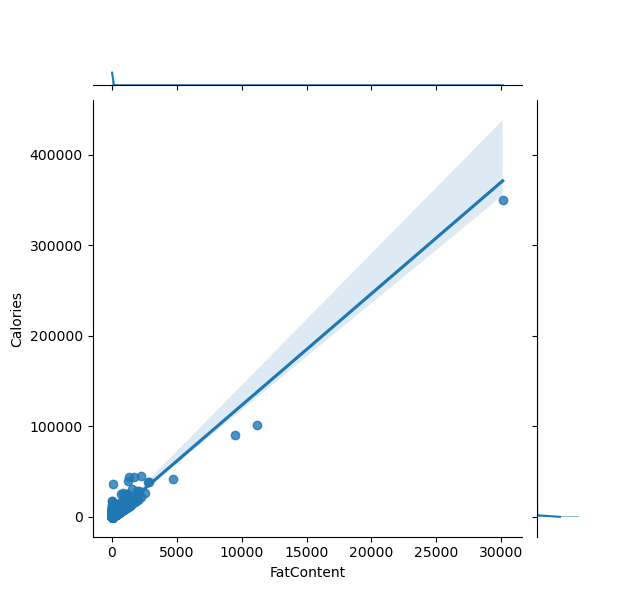

In [14]:
# Joint plot with regression line
sns.jointplot(data=df, x='FatContent', y='Calories', kind='reg')
plt.show()

In [15]:
# Create a new DataFrame containing relevant columns
health_calories = df[['Health', 'Calories']]

# Drop rows with missing values in 'Calories' column
health_calories.dropna(subset=['Calories'], inplace=True)


C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\1765930190.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_calories.dropna(subset=['Calories'], inplace=True)


In [19]:
# Filter out rows with the "Bath/Beauty" keyword
df_health_calories = df[df['Health'] != 'Bath/Beauty']

# Group by "Health" and calculate the mean of "Calories" for each health category
calories_mean = df_health_calories.groupby('Health')['Calories'].mean().sort_values()

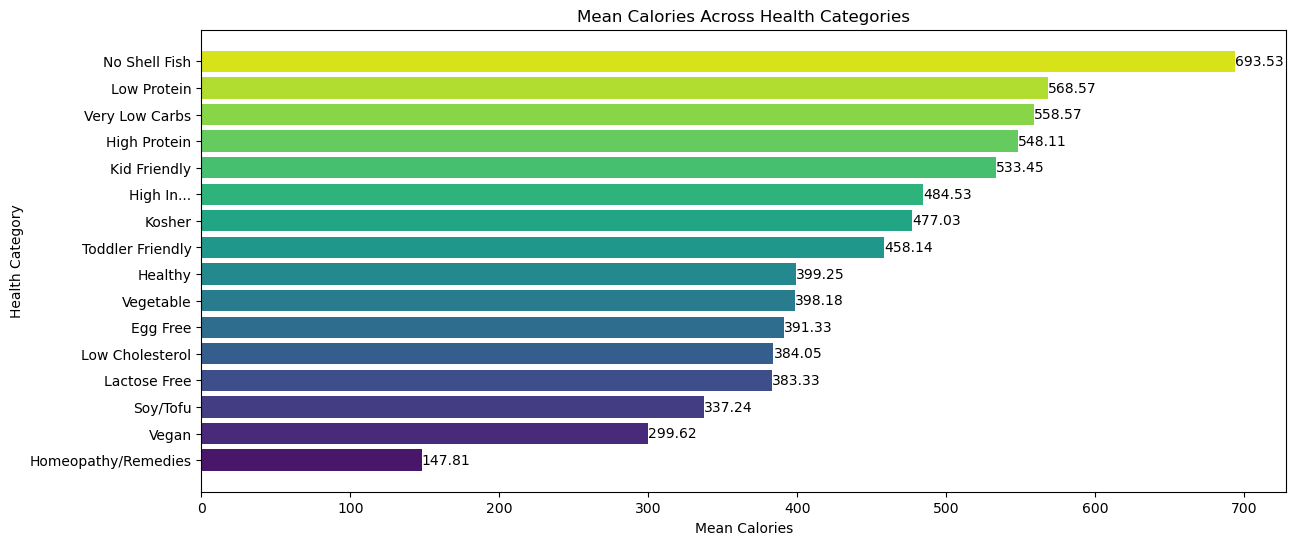

In [25]:
# Filter out the empty category
calories_mean_filtered = calories_mean[calories_mean.index != '']

# Define a color palette
colors = sns.color_palette('viridis', len(calories_mean_filtered))

# Plot the bar chart with the specified color palette
plt.figure(figsize=(14, 6))
bars = plt.barh(range(len(calories_mean_filtered)), calories_mean_filtered.values, color=colors)

# Add the values to each bar
for i, value in enumerate(calories_mean_filtered.values):
    plt.text(value, i, '{:.2f}'.format(value), va='center', fontsize=10, color='black')

# Set yticks and labels
plt.yticks(range(len(calories_mean_filtered)), calories_mean_filtered.index)

plt.xlabel('Mean Calories')
plt.ylabel('Health Category')
plt.title('Mean Calories Across Health Categories')
plt.savefig('../images/mean_calories.jpg', transparent = True)
plt.show()

In [21]:
# Create a new DataFrame containing relevant columns
health_fat_content = df[['Health', 'FatContent']]

# Drop rows with missing values in 'FatContent' column
health_fat_content.dropna(subset=['FatContent'], inplace=True)

# Convert 'FatContent' column to numeric (assuming it contains numerical values)
health_fat_content['FatContent'] = pd.to_numeric(health_fat_content['FatContent'], errors='coerce')

# Perform groupby and calculate mean
fat_content_mean = health_fat_content.groupby('Health')['FatContent'].mean().sort_values(ascending=False)

C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\3033715739.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_fat_content.dropna(subset=['FatContent'], inplace=True)
C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\3033715739.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_fat_content['FatContent'] = pd.to_numeric(health_fat_content['FatContent'], errors='coerce')


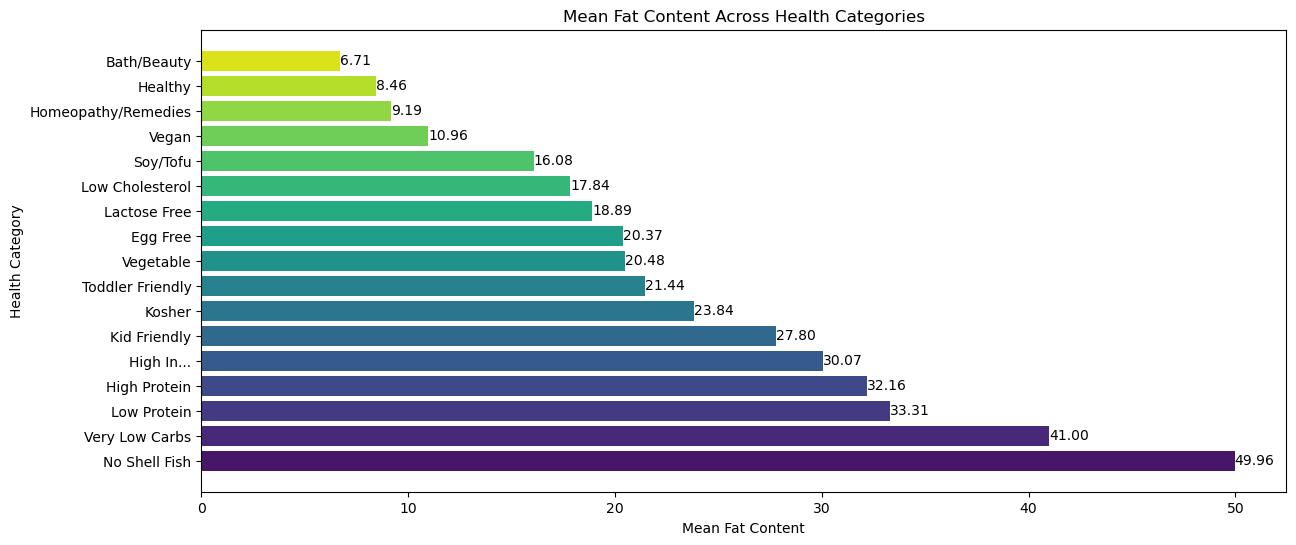

In [22]:
# Filter out the empty category
fat_content_mean_filtered = fat_content_mean[fat_content_mean.index != '']

# Define a color palette
colors = sns.color_palette('viridis', len(fat_content_mean_filtered))

# Plot the bar chart with the specified color palette
plt.figure(figsize=(14, 6))
bars = plt.barh(range(len(fat_content_mean_filtered)), fat_content_mean_filtered.values, color=colors)

# Add the values to each bar
for i, value in enumerate(fat_content_mean_filtered.values):
    plt.text(value, i, '{:.2f}'.format(value), va='center', fontsize=10, color='black')

# Set yticks and labels
plt.yticks(range(len(fat_content_mean_filtered)), fat_content_mean_filtered.index)

plt.xlabel('Mean Fat Content')
plt.ylabel('Health Category')
plt.title('Mean Fat Content Across Health Categories')
plt.savefig('../images/mean_fat_content.jpg')
plt.show()

In [23]:
# Create a new DataFrame containing relevant columns
health_sugar_content = df[['Health', 'SugarContent']]

# Drop rows with missing values in 'SugarContent' column
health_sugar_content.dropna(subset=['SugarContent'], inplace=True)

# Convert 'SugarContent' column to numeric (assuming it contains numerical values)
health_sugar_content['SugarContent'] = pd.to_numeric(health_sugar_content['SugarContent'], errors='coerce')

# Perform groupby and calculate mean
sugar_content_mean = health_sugar_content.groupby('Health')['SugarContent'].mean().sort_values(ascending=False)


C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\1689112734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_sugar_content.dropna(subset=['SugarContent'], inplace=True)
C:\Users\cjche\AppData\Local\Temp\ipykernel_15416\1689112734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_sugar_content['SugarContent'] = pd.to_numeric(health_sugar_content['SugarContent'], errors='coerce')


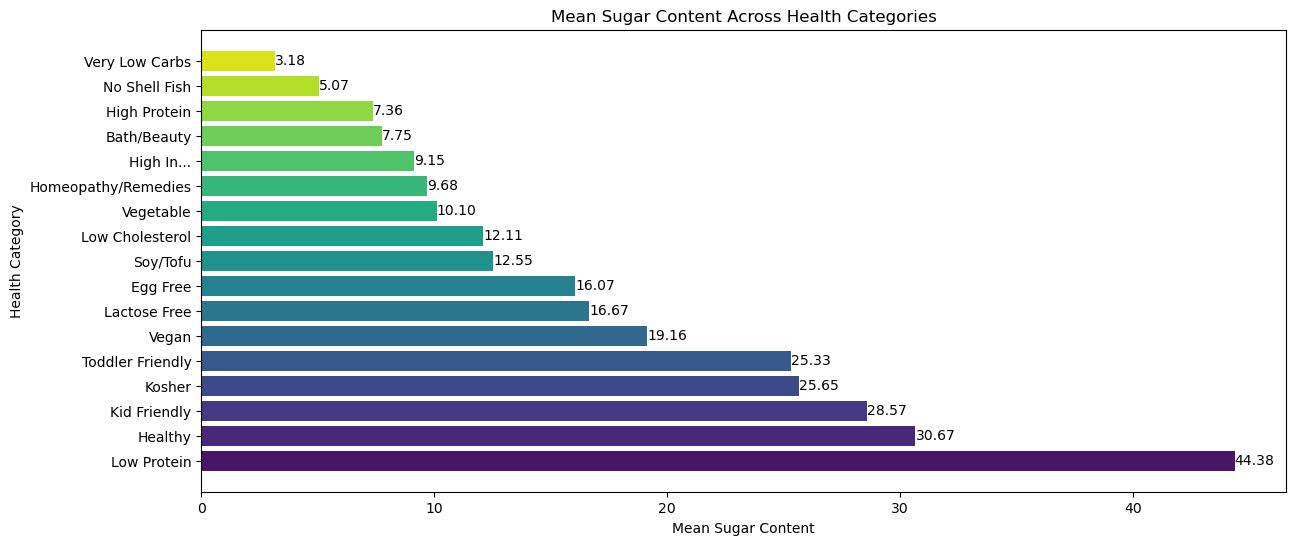

In [24]:
# Filter out the empty category
sugar_content_mean_filtered = sugar_content_mean[sugar_content_mean.index != '']

# Define a color palette
colors = sns.color_palette('viridis', len(sugar_content_mean_filtered))

# Plot the bar chart with the specified color palette
plt.figure(figsize=(14, 6))
bars = plt.barh(range(len(sugar_content_mean_filtered)), sugar_content_mean_filtered.values, color=colors)

# Add the values to each bar
for i, value in enumerate(sugar_content_mean_filtered.values):
    plt.text(value, i, '{:.2f}'.format(value), va='center', fontsize=10, color='black')

# Set yticks and labels
plt.yticks(range(len(sugar_content_mean_filtered)), sugar_content_mean_filtered.index)

plt.xlabel('Mean Sugar Content')
plt.ylabel('Health Category')
plt.title('Mean Sugar Content Across Health Categories')
plt.savefig('../images/mean_sugar_content.jpg')
plt.show()